# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')


#Mount Drive

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import File

In [27]:
try:
    org_nir_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/NIR_Data.xlsx')
    print(f"Successfully loaded data with shape: {org_nir_df.shape}")
except:
    print("Error loading data. Please check the file path.")


Successfully loaded data with shape: (773, 1040)


#EDA

In [4]:
try:
    nir_df = org_nir_df.copy()

    # Extract sample IDs
    sample_ids = nir_df['Sample ID'].values

    base_sample_ids = np.array([sid.split('.')[0] if '.' in str(sid) else str(sid) for sid in sample_ids])
    unique_samples = np.unique(base_sample_ids)

    print(f"Number of unique samples: {len(unique_samples)}")
    print(f"Number of total measurements: {len(sample_ids)}")

    # Display sample measurement counts
    sample_counts = {sample: np.sum(base_sample_ids == sample) for sample in unique_samples}
    print(f"Measurements per sample (first 5): {dict(list(sample_counts.items())[:5])}")

    # Extract spectral data (all columns except Sample ID, Unnamed: 1, and Moisture)
    spectral_cols = [col for col in nir_df.columns if col not in ['Sample ID', 'Unnamed: 1', 'Moisture']]

    print(f"Number of spectral columns: {len(spectral_cols)}")

    #cehck null values
    null_counts = nir_df[spectral_cols].isnull().sum()
    total_null_values = null_counts.sum()
    print(f"Total number of null values in spectral columns: {total_null_values}")

    wavelengths = np.array([float(col) for col in spectral_cols])



    # Convert wavelengths from wavenumbers (cm-1) to nanometers (nm)
    wavelengths = 10000000 / wavelengths
    print("****Converted wavelengths from wavenumbers (cm-1) to nanometers (nm)****")
    print(f"Wavelength range: {min(wavelengths):.2f} nm - {max(wavelengths):.2f} nm")
    # print wavelength not in range 834-2500 nm
    out_of_range_wavelengths = wavelengths[(wavelengths < 834) | (wavelengths > 2500)]
    print(f"Number of wavelengths outside the range 834-2500 nm: {out_of_range_wavelengths}")

    y = nir_df['Moisture'].values

    X = nir_df[spectral_cols].values

    print(f"Number of measurements: {len(nir_df)}")
    print(f"Number of NIR variables: {len(spectral_cols)}")
    print(f"Wavelength range: {min(wavelengths):.2f} nm - {max(wavelengths):.2f} nm")
    print(f"Moisture content range: {min(y):.2f}% - {max(y):.2f}%")

except Exception as e:
    print("Error loading data. Please check the file and column names.")

Number of unique samples: 126
Number of total measurements: 773
Measurements per sample (first 5): {np.str_('3001RanBioMixMalarenergi'): np.int64(8), np.str_('3002RanBioMixMalarenergi'): np.int64(6), np.str_('3003RanBioMixMalarenergi'): np.int64(6), np.str_('3004RanBioMixMalarenergi'): np.int64(6), np.str_('3005RanBioMixMalarenergi'): np.int64(6)}
Number of spectral columns: 1037
Total number of null values in spectral columns: 0
****Converted wavelengths from wavenumbers (cm-1) to nanometers (nm)****
Wavelength range: 834.13 nm - 2502.40 nm
Number of wavelengths outside the range 834-2500 nm: [2502.39541801]
Number of measurements: 773
Number of NIR variables: 1037
Wavelength range: 834.13 nm - 2502.40 nm
Moisture content range: 17.98% - 73.07%


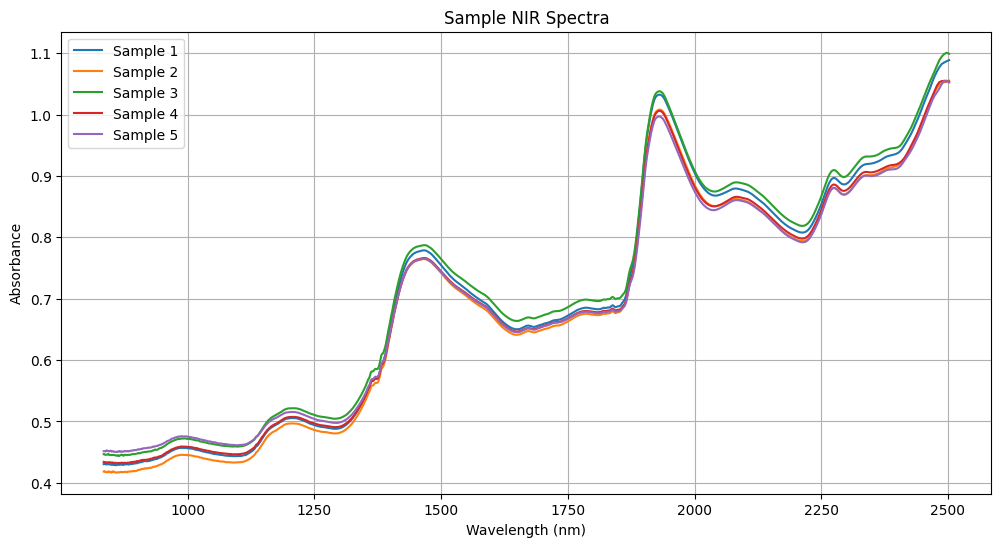

In [5]:
# Plot a few sample spectra to visualize the data
plt.figure(figsize=(12, 6))
for i in range(min(5, X.shape[0])):
    plt.plot(wavelengths, X[i], label=f"Sample {(i)+1}")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Sample NIR Spectra')
plt.legend()
plt.grid(True)
plt.show()

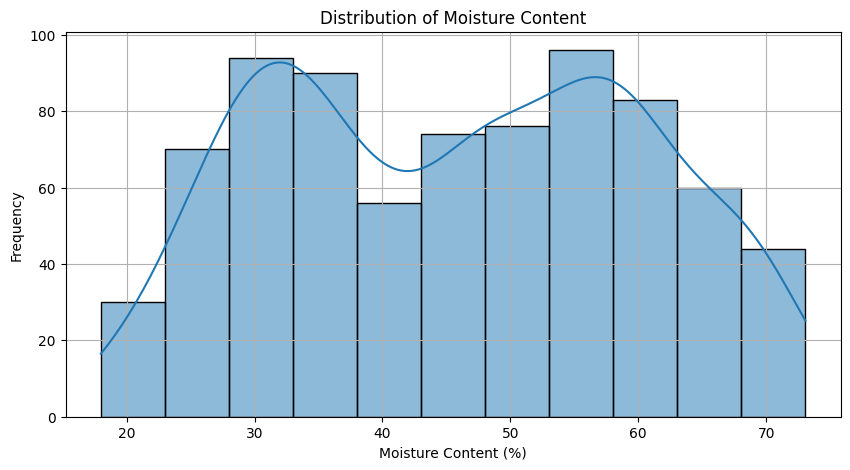

In [6]:
# Explore moisture content distribution
plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True)
plt.xlabel('Moisture Content (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Moisture Content')
plt.grid(True)
plt.show()

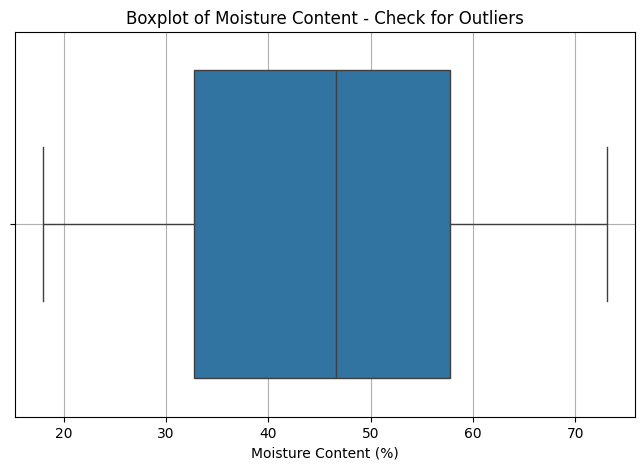

In [7]:
# Data exploration - Boxplot of moisture content
plt.figure(figsize=(8, 5))
sns.boxplot(x=y)
plt.xlabel('Moisture Content (%)')
plt.title('Boxplot of Moisture Content - Check for Outliers')
plt.grid(True)
plt.show()

# Checking for Outliers

In [8]:
# Check for outliers in spectra using PCA for visualization
# Standardize the data for PCA
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_std)

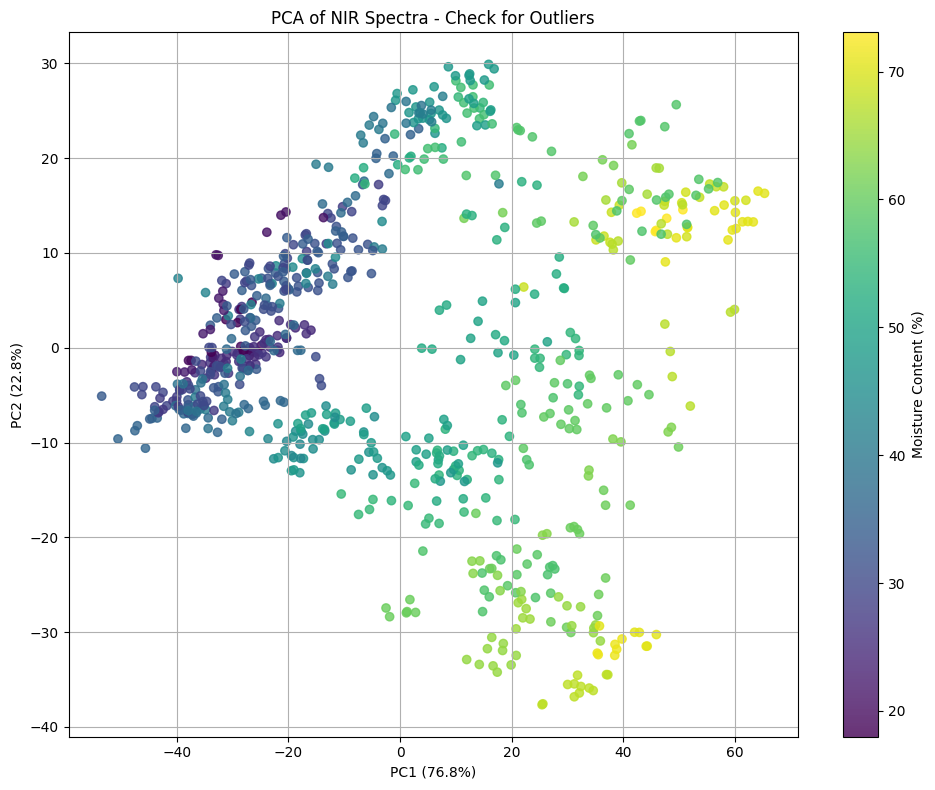

In [9]:
# Plot PCA results to identify potential outliers
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='viridis', alpha=0.8)
plt.colorbar(label='Moisture Content (%)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA of NIR Spectra - Check for Outliers')
plt.grid(True)
plt.tight_layout()
plt.show()

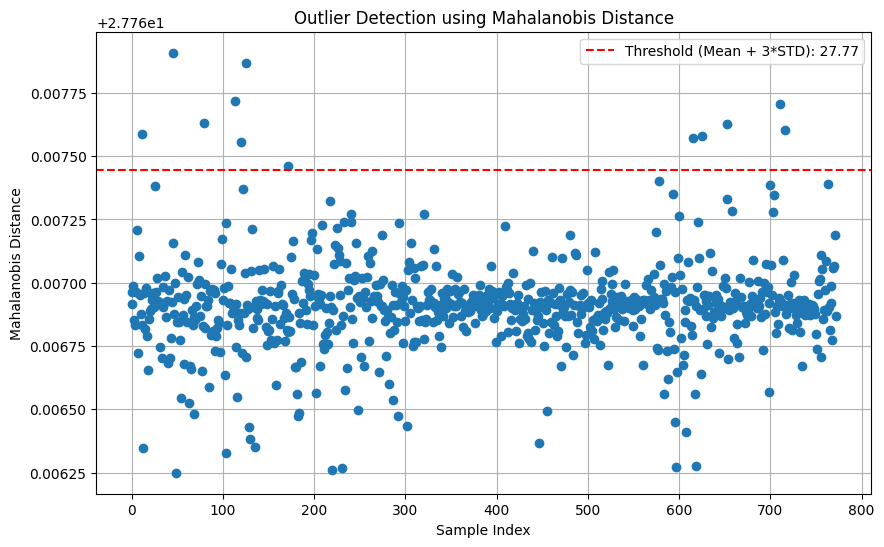

Detected 1 outlier samples: [np.str_('3128RanBioMixMalarenergi')]


In [10]:
# Identify outliers using Mahalanobis distance
X_mean = np.mean(X, axis=0)
X_cov = np.cov(X, rowvar=False)
X_cov_inv = np.linalg.pinv(X_cov)

def mahalanobis_distance(x, mean, cov_inv):
    diff = x - mean
    return np.sqrt(np.dot(np.dot(diff, cov_inv), diff.T))

mahal_dist = np.zeros(len(X))
for i in range(len(X)):
    mahal_dist[i] = mahalanobis_distance(X[i], X_mean, X_cov_inv)

# Plot Mahalanobis distances
plt.figure(figsize=(10, 6))
plt.plot(mahal_dist, 'o')
plt.axhline(y=np.mean(mahal_dist) + 3*np.std(mahal_dist), color='r', linestyle='--',
           label=f'Threshold (Mean + 3*STD): {np.mean(mahal_dist) + 3*np.std(mahal_dist):.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Mahalanobis Distance')
plt.title('Outlier Detection using Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()

# Calculate average Mahalanobis distance for each unique sample
sample_mahal_dist = {}
for sample in unique_samples:
    sample_indices = np.where(base_sample_ids == sample)[0]
    sample_mahal_dist[sample] = np.mean(mahal_dist[sample_indices])

threshold = np.mean(list(sample_mahal_dist.values())) + 3 * np.std(list(sample_mahal_dist.values()))

outlier_samples = [sample for sample in unique_samples if sample_mahal_dist[sample] > threshold]
print(f"Detected {len(outlier_samples)} outlier samples: {outlier_samples}")

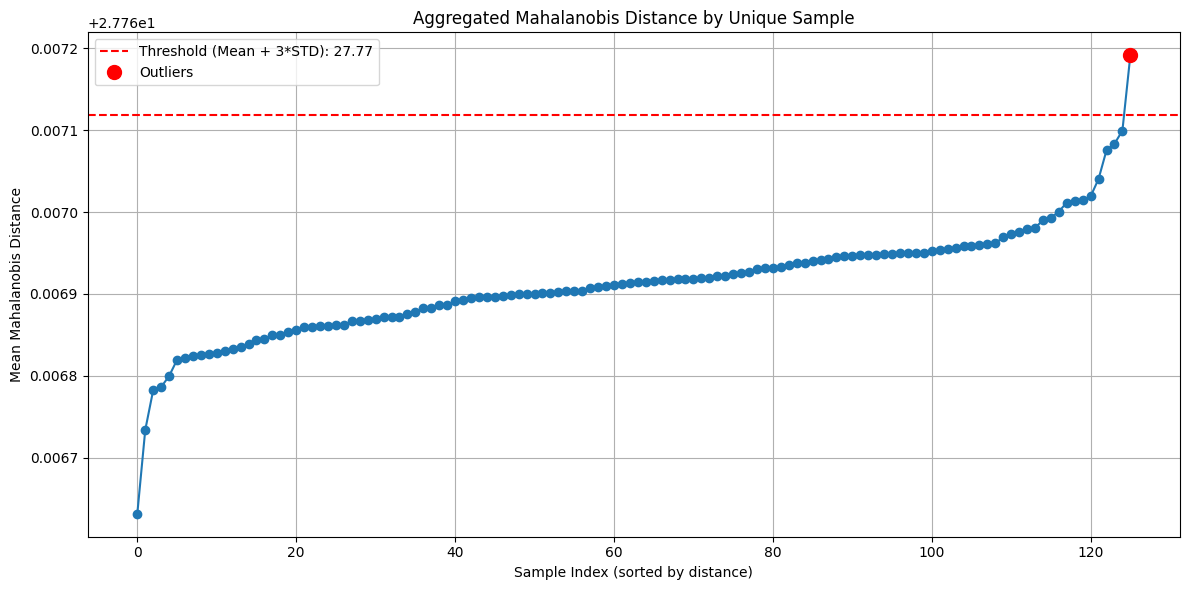

In [11]:
# Create plot of aggregated Mahalanobis distances by unique sample
plt.figure(figsize=(12, 6))
# Sort samples by their Mahalanobis distance
samples = list(sample_mahal_dist.keys())
distances = list(sample_mahal_dist.values())
sorted_indices = np.argsort(distances)
sorted_samples = [samples[i] for i in sorted_indices]
sorted_distances = [distances[i] for i in sorted_indices]

# Plot as points
plt.plot(range(len(sorted_samples)), sorted_distances, 'o-', markersize=6)

# Add threshold line
threshold = np.mean(distances) + 3 * np.std(distances)
plt.axhline(y=threshold, color='r', linestyle='--',
           label=f'Threshold (Mean + 3*STD): {threshold:.2f}')

# Highlight outliers
outlier_indices = [i for i, d in enumerate(sorted_distances) if d > threshold]
if outlier_indices:
    plt.plot([outlier_indices], [sorted_distances[i] for i in outlier_indices],
             'ro', markersize=10, label='Outliers')

plt.xlabel('Sample Index (sorted by distance)')
plt.ylabel('Mean Mahalanobis Distance')
plt.title('Aggregated Mahalanobis Distance by Unique Sample')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Identify outlier samples
outlier_samples = [sample for sample in unique_samples if sample_mahal_dist[sample] > threshold]
print(f"Detected {len(outlier_samples)} outlier samples: {outlier_samples}")

# Remove outliers at the sample level
if len(outlier_samples) > 0:
    keep_indices = [i for i, sample in enumerate(base_sample_ids) if sample not in outlier_samples]
    X_cleaned = X[keep_indices]
    y_cleaned = y[keep_indices]
    sample_ids_cleaned = sample_ids[keep_indices]
    base_sample_ids_cleaned = base_sample_ids[keep_indices]
    print(f"Shape after outlier removal: {X_cleaned.shape}")
else:
    X_cleaned = X
    y_cleaned = y
    sample_ids_cleaned = sample_ids
    base_sample_ids_cleaned = base_sample_ids
    print("No outliers removed")

Detected 1 outlier samples: [np.str_('3128RanBioMixMalarenergi')]
Shape after outlier removal: (767, 1037)


# Preprocessing

In [13]:
# Defining preprocessing methods for NIR spectroscopy
class SavitzkyGolayFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window_length=15, polyorder=3, deriv=0):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_filtered = X.copy()
        for i in range(X.shape[0]):
            X_filtered[i, :] = savgol_filter(X[i, :], self.window_length, self.polyorder, deriv=self.deriv)
        return X_filtered


In [14]:
class SNV(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = np.zeros_like(X)
        for i in range(X.shape[0]):
            # Standard Normal Variate transformation
            X_transformed[i, :] = (X[i, :] - np.mean(X[i, :])) / np.std(X[i, :])
        return X_transformed

In [15]:
class MSC(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_spectrum = None

    def fit(self, X, y=None):
        self.mean_spectrum = np.mean(X, axis=0)
        return self

    def transform(self, X):
        X_transformed = np.zeros_like(X)
        for i in range(X.shape[0]):
            # Multiplicative Scatter Correction
            slope, intercept = np.polyfit(self.mean_spectrum, X[i, :], 1)
            X_transformed[i, :] = (X[i, :] - intercept) / slope
        return X_transformed

In [16]:
def visualize_preprocessing(X_raw, method_name, X_processed):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for i in range(min(5, X_raw.shape[0])):
        plt.plot(wavelengths, X_raw[i], alpha=0.7, label=f"Sample {i+1}")
    plt.title("Raw Spectra")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorbance")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for i in range(min(5, X_processed.shape[0])):
        plt.plot(wavelengths, X_processed[i], alpha=0.7, label=f"Sample {i+1}")
    plt.title(f"After {method_name}")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Processed Values")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

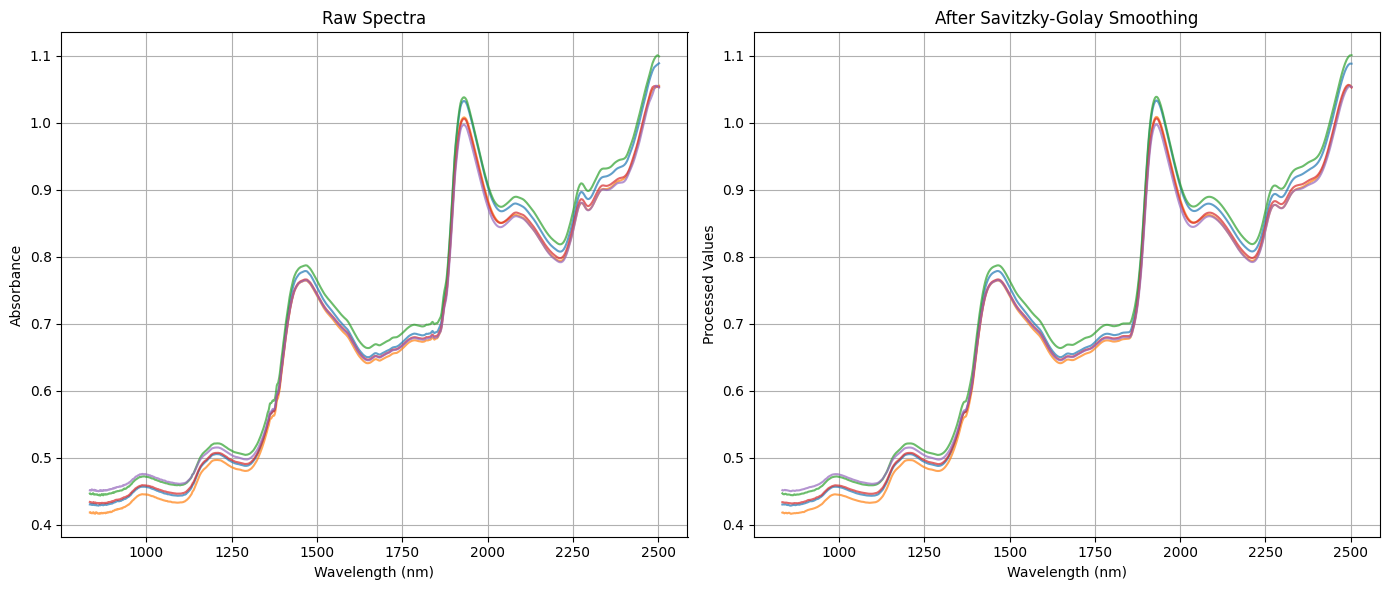

In [17]:
# Apply and visualize different preprocessing methods
# 1. Savitzky-Golay smoothing
sg_filter = SavitzkyGolayFilter(window_length=15, polyorder=3)
X_sg = sg_filter.fit_transform(X_cleaned)
visualize_preprocessing(X_cleaned, "Savitzky-Golay Smoothing", X_sg)

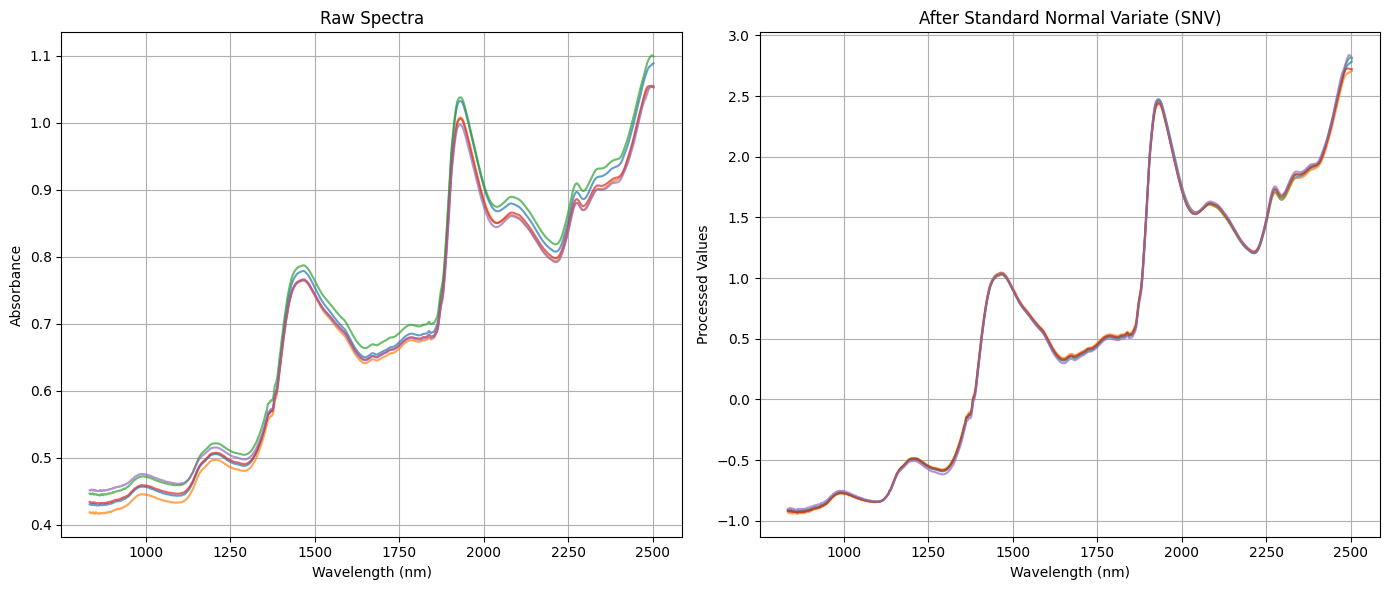

In [19]:
# 3. Standard Normal Variate (SNV)
snv = SNV()
X_snv = snv.fit_transform(X_cleaned)
visualize_preprocessing(X_cleaned, "Standard Normal Variate (SNV)", X_snv)

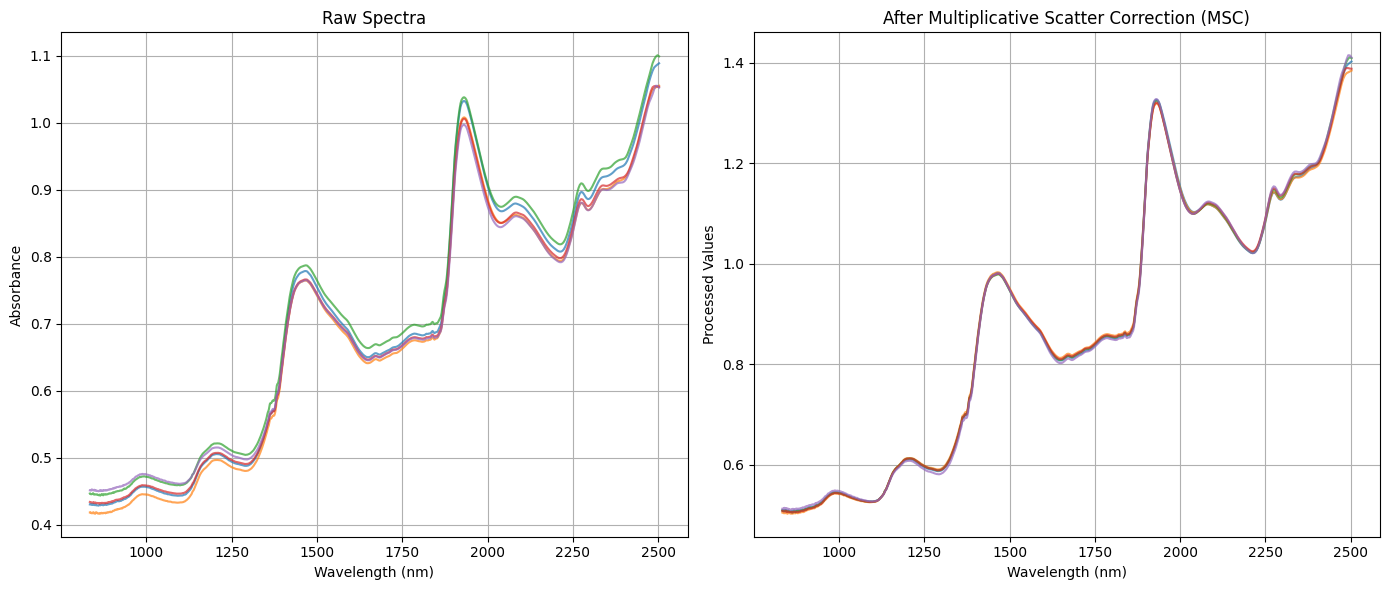

In [20]:
# 4. Multiplicative Scatter Correction (MSC)
msc = MSC()
X_msc = msc.fit_transform(X_cleaned)
visualize_preprocessing(X_cleaned, "Multiplicative Scatter Correction (MSC)", X_msc)

# Model Training

In [21]:
# Task 2: Build ML models using PLS, SVR, and ANN

# Create a dictionary to store results for comparison
results = {}

# Define preprocessing pipelines
preprocessing_methods = {
    'Raw': None,
    'SG': SavitzkyGolayFilter(window_length=15, polyorder=3),
    # 'SG+deriv1': SavitzkyGolayFilter(window_length=15, polyorder=3, deriv=1),
    'SNV': SNV(),
    'MSC': MSC(),
    'SNV+SG': Pipeline([('snv', SNV()),
                       ('sg', SavitzkyGolayFilter(window_length=15, polyorder=3))])
}

# Define models
models = {
    'PLS': PLSRegression(n_components=10),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    'ANN': MLPRegressor(hidden_layer_sizes=(100,), activation='relu',
                        solver='adam', max_iter=1000, random_state=42)
}

In [22]:
# Create a class for group-aware cross-validation
class GroupKFold(KFold):
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        # Apply KFold on unique groups
        for train_group_idx, test_group_idx in super().split(unique_groups):
            train_groups = unique_groups[train_group_idx]
            test_groups = unique_groups[test_group_idx]

            # Find indices of samples belonging to these groups
            train_indices = np.where(np.isin(groups, train_groups))[0]
            test_indices = np.where(np.isin(groups, test_groups))[0]

            yield train_indices, test_indices

# Update cross-validation with group-aware version
group_kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# Task 3: Evaluate different preprocessing and ML combinations
def evaluate_model(X, y, model, groups, preprocess=None, cv=group_kf):
    if preprocess is not None:
        X_processed = preprocess.fit_transform(X)
    else:
        X_processed = X

    # Cross-validation with grouping
    y_pred = np.zeros_like(y)
    for train_idx, test_idx in cv.split(X_processed, y, groups=groups):
        X_train, X_test = X_processed[train_idx], X_processed[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred[test_idx] = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    return r2, rmse, y_pred

In [24]:
# Evaluate all combinations of preprocessing methods and models with sample grouping
for prep_name, preprocessor in preprocessing_methods.items():
    for model_name, model in models.items():
        key = f"{prep_name}_{model_name}"
        r2, rmse, y_pred = evaluate_model(X_cleaned, y_cleaned, model,
                                          groups=base_sample_ids_cleaned,
                                          preprocess=preprocessor)
        results[key] = {
            'R2': r2,
            'RMSE': rmse,
            'Predicted': y_pred
        }
        print(f"{key}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

Raw_PLS: R² = 0.9466, RMSE = 3.3417
Raw_SVR: R² = 0.9258, RMSE = 3.9411
Raw_ANN: R² = 0.8540, RMSE = 5.5265
SG_PLS: R² = 0.9466, RMSE = 3.3424
SG_SVR: R² = 0.9257, RMSE = 3.9420
SG_ANN: R² = 0.8551, RMSE = 5.5058
SNV_PLS: R² = 0.9641, RMSE = 2.7398
SNV_SVR: R² = 0.9419, RMSE = 3.4873
SNV_ANN: R² = 0.9248, RMSE = 3.9668
MSC_PLS: R² = 0.9646, RMSE = 2.7207
MSC_SVR: R² = 0.9570, RMSE = 2.9976
MSC_ANN: R² = 0.9007, RMSE = 4.5570
SNV+SG_PLS: R² = 0.9640, RMSE = 2.7433
SNV+SG_SVR: R² = 0.9414, RMSE = 3.5004
SNV+SG_ANN: R² = 0.9270, RMSE = 3.9070


# Visualisation

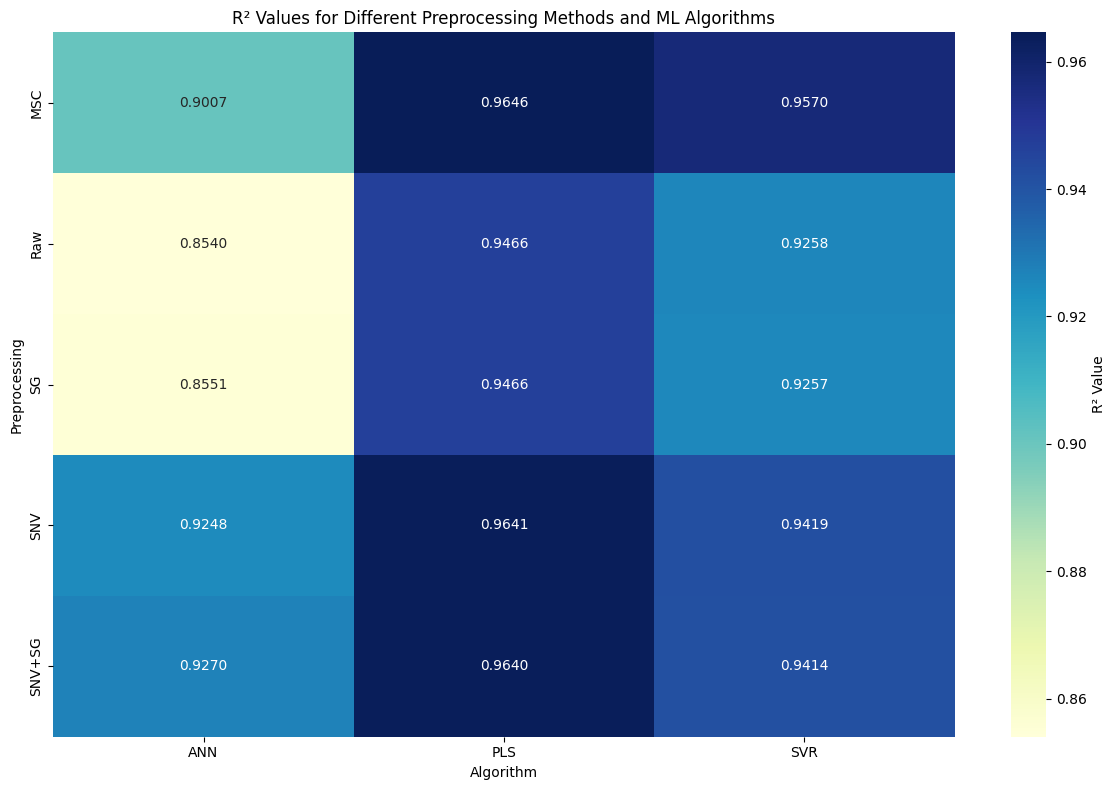

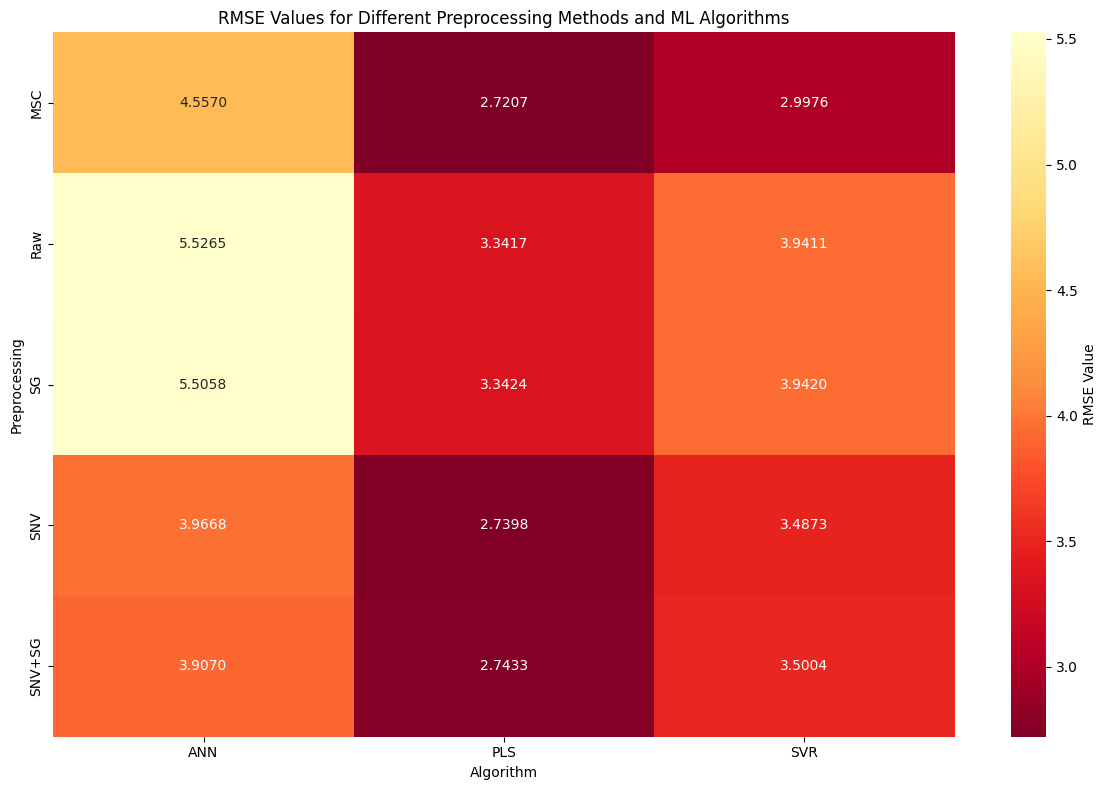


Best model: MSC_PLS
Best R²: 0.9646
Best RMSE: 2.7207


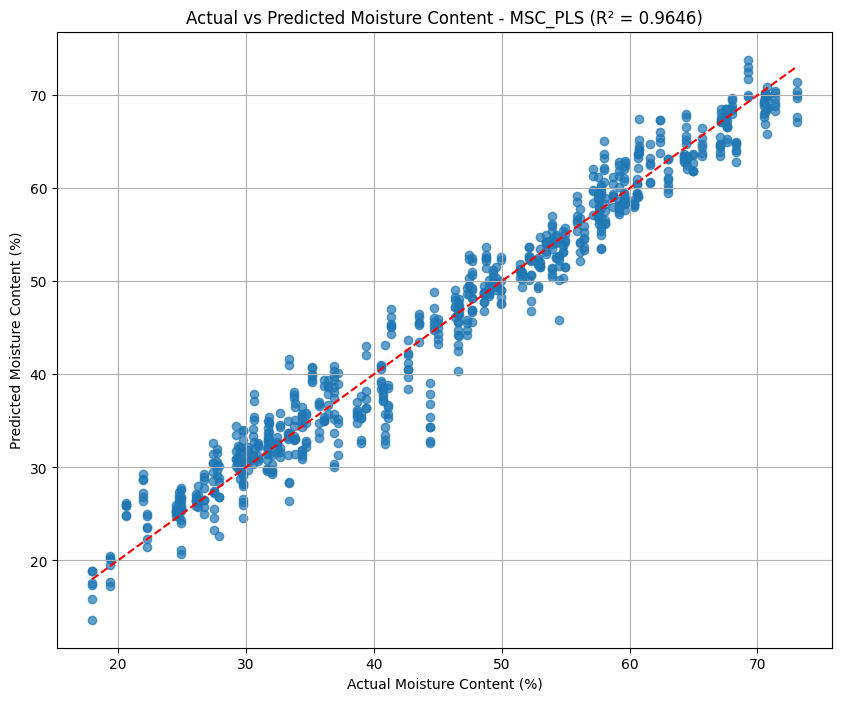

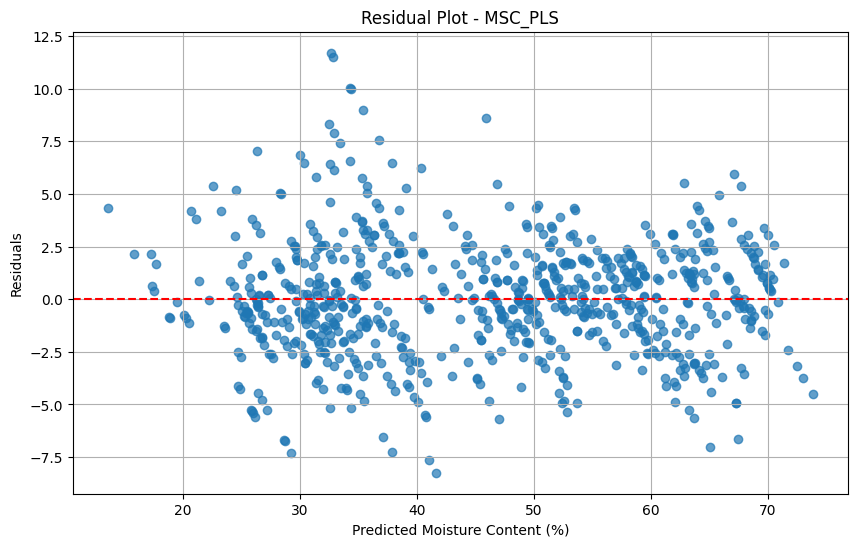


Summary of all results (sorted by R²):
   Preprocessing Model        R²      RMSE
9            MSC   PLS  0.964618  2.720681
6            SNV   PLS  0.964120  2.739775
12        SNV+SG   PLS  0.964028  2.743263
10           MSC   SVR  0.957048  2.997648
0            Raw   PLS  0.946623  3.341659
3             SG   PLS  0.946600  3.342395
7            SNV   SVR  0.941868  3.487332
13        SNV+SG   SVR  0.941430  3.500447
14        SNV+SG   ANN  0.927034  3.907041
1            Raw   SVR  0.925757  3.941061
4             SG   SVR  0.925721  3.942021
8            SNV   ANN  0.924786  3.966758
11           MSC   ANN  0.900740  4.556952
5             SG   ANN  0.855100  5.505809
2            Raw   ANN  0.854010  5.526484


In [25]:
# Visualize results in a table
results_df = pd.DataFrame({k: {'R²': v['R2'], 'RMSE': v['RMSE']} for k, v in results.items()}).T
results_df.index.name = 'Model'
results_df = results_df.reset_index()
# Split the 'Model' column into two based on the first underscore
results_df[['Preprocessing', 'Algorithm']] = results_df['Model'].str.split('_', expand=True)
results_df = results_df.pivot(index='Preprocessing', columns='Algorithm', values=['R²', 'RMSE'])


# Visualize R² results
plt.figure(figsize=(12, 8))
sns.heatmap(results_df['R²'], annot=True, cmap="YlGnBu", fmt='.4f', cbar_kws={'label': 'R² Value'})
plt.title('R² Values for Different Preprocessing Methods and ML Algorithms')
plt.tight_layout()
plt.show()

# Visualize RMSE results
plt.figure(figsize=(12, 8))
sns.heatmap(results_df['RMSE'], annot=True, cmap="YlOrRd_r", fmt='.4f', cbar_kws={'label': 'RMSE Value'})
plt.title('RMSE Values for Different Preprocessing Methods and ML Algorithms')
plt.tight_layout()
plt.show()

# Find best model based on R²
best_model_key = max(results.keys(), key=lambda k: results[k]['R2'])
best_r2 = results[best_model_key]['R2']
best_rmse = results[best_model_key]['RMSE']
best_y_pred = results[best_model_key]['Predicted']

print(f"\nBest model: {best_model_key}")
print(f"Best R²: {best_r2:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")

# Plot actual vs predicted for best model
plt.figure(figsize=(10, 8))
plt.scatter(y_cleaned, best_y_pred, alpha=0.7)
plt.plot([min(y_cleaned), max(y_cleaned)], [min(y_cleaned), max(y_cleaned)], 'r--')
plt.xlabel('Actual Moisture Content (%)')
plt.ylabel('Predicted Moisture Content (%)')
plt.title(f'Actual vs Predicted Moisture Content - {best_model_key} (R² = {best_r2:.4f})')
plt.grid(True)
plt.show()

# Calculate residuals
residuals = y_cleaned - best_y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(best_y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Moisture Content (%)')
plt.ylabel('Residuals')
plt.title(f'Residual Plot - {best_model_key}')
plt.grid(True)
plt.show()

# Summary table of all results
summary_df = pd.DataFrame(columns=['Preprocessing', 'Model', 'R²', 'RMSE'])
for key, values in results.items():
    prep, model = key.split('_')
    summary_df = pd.concat([summary_df, pd.DataFrame({
        'Preprocessing': [prep],
        'Model': [model],
        'R²': [values['R2']],
        'RMSE': [values['RMSE']]
    })], ignore_index=True)

summary_df = summary_df.sort_values('R²', ascending=False)
print("\nSummary of all results (sorted by R²):")
print(summary_df)

In [26]:
# Summary table of all results
summary_df = pd.DataFrame(columns=['Preprocessing', 'Model', 'R²', 'RMSE'])
for key, values in results.items():
    prep, model = key.split('_')
    summary_df = pd.concat([summary_df, pd.DataFrame({
        'Preprocessing': [prep],
        'Model': [model],
        'R²': [values['R2']],
        'RMSE': [values['RMSE']]
    })], ignore_index=True)

summary_df = summary_df.sort_values('R²', ascending=False)
print("\nSummary of all results (sorted by R²):")
print(summary_df)


Summary of all results (sorted by R²):
   Preprocessing Model        R²      RMSE
9            MSC   PLS  0.964618  2.720681
6            SNV   PLS  0.964120  2.739775
12        SNV+SG   PLS  0.964028  2.743263
10           MSC   SVR  0.957048  2.997648
0            Raw   PLS  0.946623  3.341659
3             SG   PLS  0.946600  3.342395
7            SNV   SVR  0.941868  3.487332
13        SNV+SG   SVR  0.941430  3.500447
14        SNV+SG   ANN  0.927034  3.907041
1            Raw   SVR  0.925757  3.941061
4             SG   SVR  0.925721  3.942021
8            SNV   ANN  0.924786  3.966758
11           MSC   ANN  0.900740  4.556952
5             SG   ANN  0.855100  5.505809
2            Raw   ANN  0.854010  5.526484
